In [1]:
import tarfile
import os
import sys
import logging
import re
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
from shapely.geometry import LineString, Polygon

In [2]:
def extract(tar_path, target_path = 'tmp', mode = 'r:gz', logger = None):
    """
    input:
        tar_path string:
            path of tar file
        target_path string:
            path of target file
        mode string:
            mode of tar 
    """
    try:
        tar = tarfile.open(tar_path, mode)
        file_names = tar.getnames()
        # make sure that only two files contain
        #assert(len(file_names) == 2)
        # make sure the name of the files is right
        #TODO
        confs = []
        results = []
        if logger:
            logger.info('start extracting data from file: '+tar_path)
        file_names = [li for li in file_names if li.split('.')[-1] == 'txt']
        # logging start info
        for file_name in file_names:
            f = tar.extractfile(file_name)
            if 'configuration' in file_name:
                # use the configuration filename to get the result filename
                result_filename = file_name[:-18]+'.txt'
                # make sure the result file exist
                if result_filename not in file_names:
                    if logger:
                        logger.info('result file not found')
                    continue
                # extract the configuration file 
                f = tar.extractfile(file_name)
                conf = extract_configuration(file_name, f)
                # extract the result file
                f = tar.extractfile(result_filename)
                result = extract_result(file_name, f)
                # if mismatch 
                if len(conf) == len(result):
                    confs.append(conf)
                    results.append(result)
                elif len(conf) > len(result):
                    conf = conf[:len(result)]
                    confs.append(conf)
                    results.append(result)
                else:
                    if logger:
                        logger.error('Data mismatch in:'+ file_name)
                    else:
                        print('Data mismatch in:'+ file_name)
        tar.close()
        # combine conf and result
        conf = pd.concat(confs, axis = 0)
        result = pd.concat(results, axis = 0)
        target = pd.concat([conf, result], axis = 1)
        # extract new features from the features we get above
        target['Area'] = target['Shapely Polygon'].map(lambda x: x.area)
        target['Length'] = target['Shapely Polygon'].map(lambda x: x.length)
        target['Left down'] = target.apply(get_left_down, axis = 1)
        target['right down'] = target.apply(get_right_down, axis = 1)
        if logger:
            logger.info('end extracting')
        return target
    except:
        raise

def extract_configuration(filename, f):
    """
    input:
        filename string:
            the name of the file, only works when the filename doesn't contain other number
        f file object:
            the file object
    """
    conf_columns = ['Jobid', 'Rot', 'List of Coordinates', 'Shapely Polygon']
    conf = pd.DataFrame(columns = conf_columns)
    for row_index, line in enumerate(f):
        l = line.decode("utf-8").strip()
        l = re.sub(r'\s+', ' ', l)
        ws = l.split(' ')
        assert(len(ws)>=2)
        conf.loc[row_index, 'Jobid'] = re.sub('[a-zA-Z/.]', '', filename)+str(row_index)
        conf.loc[row_index, 'Rot'] = ws[0]
        tmp_coor = fix_coordinate(ws[1:])
        conf.loc[row_index, 'List of Coordinates'] = tmp_coor
        conf.loc[row_index, 'Shapely Polygon'] = Polygon(tmp_coor)
    return conf

def extract_result(filename, f):
    """
    input:
        filename string:
            the name of the file
        f file object:
            the file object    
    """
    result_columns = ['Metric1', 'Metric2', 'Metric3', 'Metric4']
    result = pd.DataFrame(columns = result_columns)
    for row_index, line in enumerate(f):
        l = line.decode("utf-8").strip()
        l = re.sub(r'\s+', ' ', l)
        ws = l.split(' ')
        if len(ws) != 6:
            print(ws)
        result.loc[row_index, 'Metric1'] = ws[2]
        result.loc[row_index, 'Metric2'] = ws[3]
        result.loc[row_index, 'Metric3'] = ws[4]
        result.loc[row_index, 'Metric4'] = ws[5]
    return result

def fix_coordinate(ws, logger = None):
    out = []
    out2 = []
    for w in ws:
        if w.count('.') == 1:
            out.append(float(w))
        elif w.count('.') > 1:
            # fix the problem
            tmp = []
            get_first(w, tmp)
            out.extend(tmp)
        else:
            # error??
            if logger:
                logger.error('coordinate error')
    if len(out)%2 != 0:
        logger.error('coordinate error')
    for i in range(0,len(out),2):
        out2.append((out[i],out[i+1]))
    return out2

def get_left_down(line):
    """
    !Attention: (0,0) is on left up side
    input:
      line: a line of the dataset
    attribute:
      sp, type of polygon
      rotation, type of int
        grad of rotation
      x, type of int
        right-up x coordinate after rotation
      y, type of int
        right-up y coordinate after rotation
    """
    sp = line['Shapely Polygon']
    rotation = line['Rot']
    x = float(line['Metric2'])
    y = float(line['Metric3'])
    _, _, l1, l2 = sp.bounds
    if rotation == '0.00':
        return (x + l1, y)
    elif rotation == '90.00':
        return (x + l2, y)
    else:
        print('false rotation inputted!!!' + str(rotation))
        return 0, 0
# ------------------------------------------------------    
def get_right_down(line):
    """
    !Attention: (0,0) is on left up side
    input:
      line: a line of the dataset
    attribute:
      sp, type of polygon
      rotation, type of int
        grad of rotation
      x, type of int
        right-up x coordinate after rotation
      y, type of int
        right-up y coordinate after rotation
    """
    sp = line['Shapely Polygon']
    rotation = line['Rot']
    x = float(line['Metric2'])
    y = float(line['Metric3'])
    _, _, l1, l2 = sp.bounds
    if rotation == '0.00':
        return (x + l1, y+l2)
    elif rotation == '90.00':
        return (x + l2, y+l1)
    else:
        print('false rotation inputted!!!' + str(rotation))
        return 0, 0
    
# ------------------------------------------------------

In [3]:
def get_first(li, out):
    if li.count('.') > 1:
        add = li.index('.')+3
        out.append(float(li[:add]))
        get_first(li[add:], out)
    else:
        out.append(float(li))     

## main

In [7]:
# set logging
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.FileHandler('E:/Teco/Trumpf/look/log/extract_data.log')
handler.setLevel(logging.INFO)
formater = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formater)
logger = logging.getLogger(__name__)
logger.addHandler(handler)
#logger.info('This is a log info')

In [8]:
# read filename
filenames = os.listdir('E:/Teco/Trumpf/look/data/')
filenames = [li for li in filenames if li.split('.')[-1] == 'tgz']
preffix = 'E:/Teco/Trumpf/look/data/'
filenames = [preffix+li for li in filenames]

In [10]:
# extract file
data = []
for filename in filenames:
    data.append(extract(filename, logger = logger))
data = pd.concat(data, axis = 0)

2019-02-07 13:56:44,460 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-2000_results.tgz
2019-02-07 13:56:47,926 - __main__ - INFO - end extracting
2019-02-07 13:56:47,954 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-2010_results.tgz
2019-02-07 13:56:51,686 - __main__ - INFO - end extracting
2019-02-07 13:56:51,718 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-2011_results.tgz
2019-02-07 13:56:55,347 - __main__ - INFO - end extracting
2019-02-07 13:56:55,364 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-2015_results.tgz
2019-02-07 13:56:58,484 - __main__ - INFO - end extracting
2019-02-07 13:56:58,506 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-2023_results.tgz
2019-02-07 13:57:02,188 - __main__ - INFO - end extracting
2019-02-07 13:57:02,212 - __main__ - INFO - start extracting data from file: E:/

2019-02-07 13:59:29,462 - __main__ - INFO - end extracting
2019-02-07 13:59:29,482 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-4946_results.tgz
2019-02-07 13:59:33,125 - __main__ - INFO - end extracting
2019-02-07 13:59:33,143 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-4947_results.tgz
2019-02-07 13:59:36,511 - __main__ - INFO - end extracting
2019-02-07 13:59:36,520 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-4950_results.tgz
2019-02-07 13:59:40,392 - __main__ - INFO - end extracting
2019-02-07 13:59:40,407 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-4951_results.tgz
2019-02-07 13:59:44,031 - __main__ - INFO - end extracting
2019-02-07 13:59:44,051 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-4952_results.tgz
2019-02-07 13:59:47,651 - __main__ - INFO - end extracting
2019-02-07 13:59:47,6

2019-02-07 14:02:13,194 - __main__ - INFO - end extracting
2019-02-07 14:02:13,212 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-6702_results.tgz
2019-02-07 14:02:16,848 - __main__ - INFO - end extracting
2019-02-07 14:02:16,865 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-6704_results.tgz
2019-02-07 14:02:20,502 - __main__ - INFO - end extracting
2019-02-07 14:02:20,520 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-6705_results.tgz
2019-02-07 14:02:24,392 - __main__ - INFO - end extracting
2019-02-07 14:02:24,397 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-6706_results.tgz
2019-02-07 14:02:28,016 - __main__ - INFO - end extracting
2019-02-07 14:02:28,025 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-6707_results.tgz
2019-02-07 14:02:31,545 - __main__ - INFO - end extracting
2019-02-07 14:02:31,5

2019-02-07 14:04:55,939 - __main__ - INFO - end extracting
2019-02-07 14:04:55,944 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-8462_results.tgz
2019-02-07 14:04:59,641 - __main__ - INFO - end extracting
2019-02-07 14:04:59,650 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-8487_results.tgz
2019-02-07 14:05:03,424 - __main__ - INFO - end extracting
2019-02-07 14:05:03,433 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-8489_results.tgz
2019-02-07 14:05:07,299 - __main__ - INFO - end extracting
2019-02-07 14:05:07,310 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-8490_results.tgz
2019-02-07 14:05:10,953 - __main__ - INFO - end extracting
2019-02-07 14:05:10,964 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-8491_results.tgz
2019-02-07 14:05:14,328 - __main__ - INFO - end extracting
2019-02-07 14:05:14,3

2019-02-07 14:07:38,778 - __main__ - INFO - end extracting
2019-02-07 14:07:38,790 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-9973_results.tgz
2019-02-07 14:07:42,362 - __main__ - INFO - end extracting
2019-02-07 14:07:42,376 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-9975_results.tgz
2019-02-07 14:07:46,111 - __main__ - INFO - end extracting
2019-02-07 14:07:46,124 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-9977_results.tgz
2019-02-07 14:07:49,871 - __main__ - INFO - end extracting
2019-02-07 14:07:49,878 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-9978_results.tgz
2019-02-07 14:07:53,451 - __main__ - INFO - end extracting
2019-02-07 14:07:53,468 - __main__ - INFO - start extracting data from file: E:/Teco/Trumpf/look/data/92600-9979_results.tgz
2019-02-07 14:07:56,946 - __main__ - INFO - end extracting
2019-02-07 14:07:56,9

In [11]:
# ------------------------------------------------------
score = [0,0,0,3.5,4,0.5]
def score_mapping(x):
    x= int(x)
    return score[x]

# ------------------------------------------------------

In [12]:
#------------------------------------------------------
data["score"] = data["Metric4"].astype(float).map(score_mapping)
#------------------------------------------------------

In [13]:
data.to_pickle('sample.tmp')

In [18]:
# save file
data[:1000000].to_pickle('../sample.tmp')

In [19]:
data[1000000:2000000].to_pickle('../sample1.tmp')

In [20]:
data[2000000:3000000].to_pickle('../sample2.tmp')

In [21]:
data[3000000:4000000].to_pickle('../sample3.tmp')

In [22]:
data[4000000:].to_pickle('../sample4.tmp')

In [85]:
data.iloc[1, 3].bounds

(0.0, 0.0, 103.6, 123.3)

In [13]:
len(data)

4649669

In [101]:
data.apply(lambda x: int(x['Rot']), axis = 1)

AttributeError: 'list' object has no attribute 'apply'

In [120]:
filenames = filenames[:1000]

In [141]:
len([float(i) for i in a["List of Coordinates"].iloc[0]])

26

In [154]:
list1

[(28.5, 60.1),
 (84.4, 88.3),
 (88.0, 80.5),
 (60.1, 28.5),
 (8.1, 0.5),
 (0.3, 4.1),
 (28.5, 0.0),
 (0.0, 7.9),
 (15.4, 16.2),
 (20.0, 13.4),
 (13.4, 20.0),
 (16.2, 15.5),
 (7.9, 0.0)]

In [145]:
list1 = []
temp = [float(i) for i in a["List of Coordinates"].iloc[0]]
for i in range(0,25,2):
    list1.append((temp[i],temp[i+1]))
    
line = LineString(list1)

In [61]:
import matplotlib.pyplot as plt
x,y = line.xy
plt.figure()
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
plt.set_title('Polygon')

NameError: name 'line' is not defined

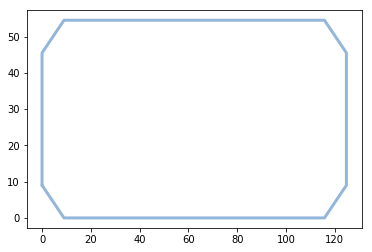

In [157]:
#[0 9; 9 0; 115.8 0; 124.8 9; 124.8 45.5; 115.8 54.5; 9 54.5; 0 45.5; 0 9]

x = [0,9,115.8,124.8,124.8,115.8,9,0,0]
y = [9, 0, 0, 9, 45.5, 54.5, 54.5, 45.5, 9]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

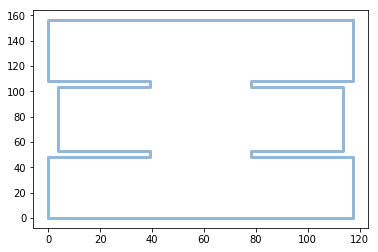

In [164]:
tmp = '117.4 156.1; 117.4 108; 78.2 108; 78.2 103; 113.6 103; 113.6 53; 78.2 53; 78.2 48; 117.4 48; 117.4 0; 0 0; 0 48; 39.2 48; 39.2 53; 3.8 53; 3.8 103; 39.2 103; 39.2 108; 0 108; 0 156.1; 117.4 156.1'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

In [168]:
figure = LineString(xy)
figure.bounds

(0.0, 0.0, 117.4, 156.1)

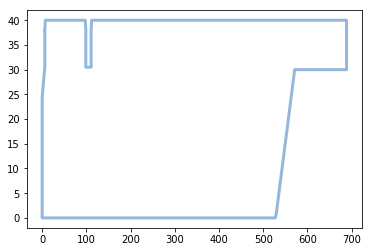

In [5]:
tmp = '6 38; 7.1 40; 97.5 40; 98.7 38; 98.7 30.5; 110.7 30.5; 110.7 38; 111.8 40; 688.3 40; 688.3 30; 571 30; 529.2 0.7; 526.9 0; 0 0; 0 24.5; 6 30.5; 6 38'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

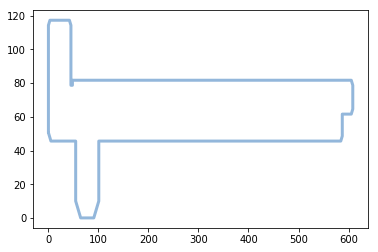

In [62]:
tmp = '0 50.6; 0 114.3; 3 117.3; 42 117.3; 45 114.3; 45 78.7; 48 78.7; 48 81.7; 605.5 81.7; 608.5 78.7; 608.5 64.6; 605.5 61.6; 587.5 61.6; 587.5 48.6; 584.5 45.6; 100.7 45.6; 100.7 10; 90.7 0; 64.5 0; 54.5 10; 54.5 45.6; 5 45.6; 0 50.6'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

In [63]:
LineString(tmp)

AssertionError: 

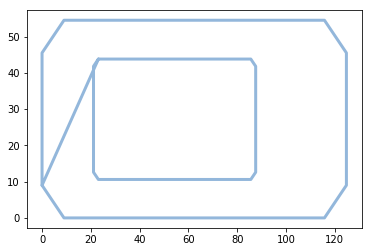

In [7]:
tmp = '0 9; 9 0; 115.8 0; 124.8 9; 124.8 45.5; 115.8 54.5; 9 54.5; 0 45.5; 0 9; 23.1 43.8; 85.6 43.8; 87.6 41.8; 87.6 12.6; 85.6 10.6; 23.1 10.6; 21.1 12.6; 21.1 41.8; 23.1 43.8'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

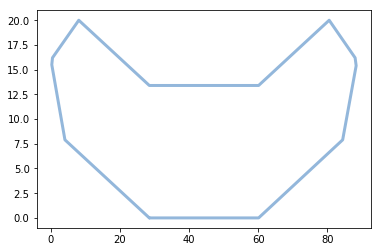

In [8]:
tmp = '28.5 0; 60.1 0; 84.4 7.9; 88.3 15.4; 88 16.2; 80.5 20; 60.1 13.4; 28.5 13.4; 8.1 20; 0.5 16.2; 0.3 15.5; 4.1 7.9; 28.5 0'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

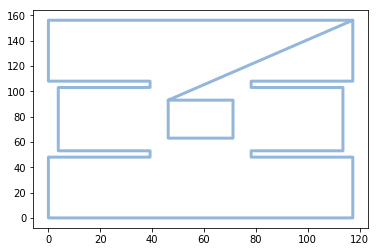

In [10]:
tmp = '117.4 156.1; 117.4 108; 78.2 108; 78.2 103; 113.6 103; 113.6 53; 78.2 53; 78.2 48; 117.4 48; 117.4 0; 0 0; 0 48; 39.2 48; 39.2 53; 3.8 53; 3.8 103; 39.2 103; 39.2 108; 0 108; 0 156.1; 117.4 156.1; 46.2 93; 46.2 63; 71.2 63; 71.2 93; 46.2 93'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

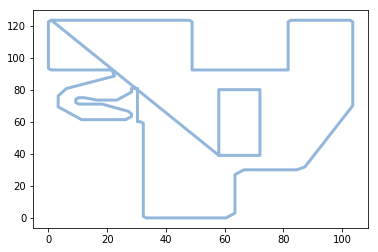

In [11]:
tmp = '1 123.3; 0 122.3; 0 93.3; 1 92.3; 21.6 92.3; 22.5 88.5; 6.1 80.7; 3.34 76.1; 3.3 69.3; 11.3 61.3; 26.3 61.3; 28.3 63.3; 28.3 64.8; 27.2 66.5; 18.3 71; 10.3 71; 9.3 72; 9.3 74; 10.3 75; 12.1 75; 12.5 74.9; 16.1 73.6; 16.5 73.5; 23.3 73.5; 28.3 78.5; 28.3 80.8; 30.3 80.8; 30.3 60; 31.3 60; 32.3 59; 32.3 1; 33.3 0; 60.5 0; 63.5 3; 63.5 27; 66.5 30; 84.5 30; 87.3 31.8; 103.5 69.8; 103.6 70.2; 103.6 122.3; 102.6 123.3; 82.6 123.3; 81.6 122.3; 81.6 92.3; 48.9 92.3; 48.9 122.3; 47.9 123.3; 1 123.3; 58 39; 58 80; 72 80; 72 39; 58 39'
ls = tmp.split(';')
ls = [l.strip() for l in ls]
x = [float(l.split(' ')[0]) for l in ls]
y = [float(l.split(' ')[1]) for l in ls]
xy = [(ll, lr) for ll, lr in zip(x, y)]
plt.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

In [74]:
line = Polygon([(0, 0), (1, 1), (1, 2)])

In [75]:
line.area

0.5

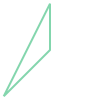

In [67]:
line